<IPython.core.display.Javascript object>


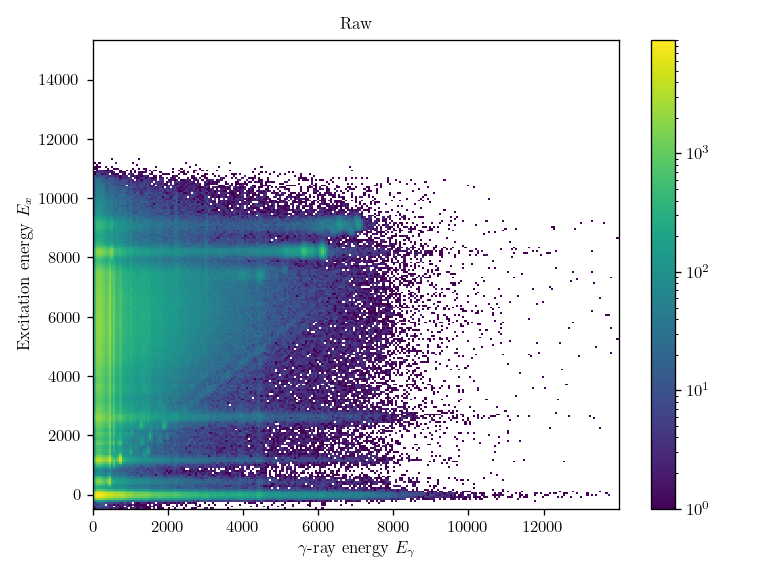

<IPython.core.display.Javascript object>


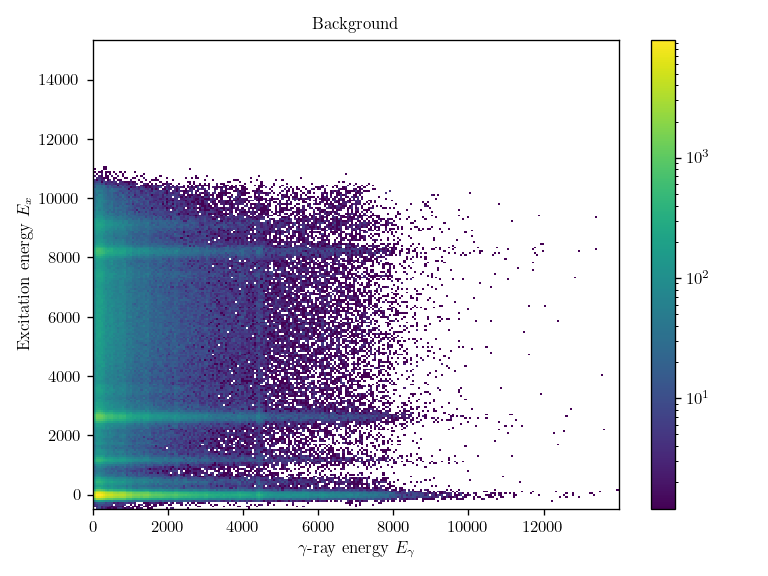

<IPython.core.display.Javascript object>


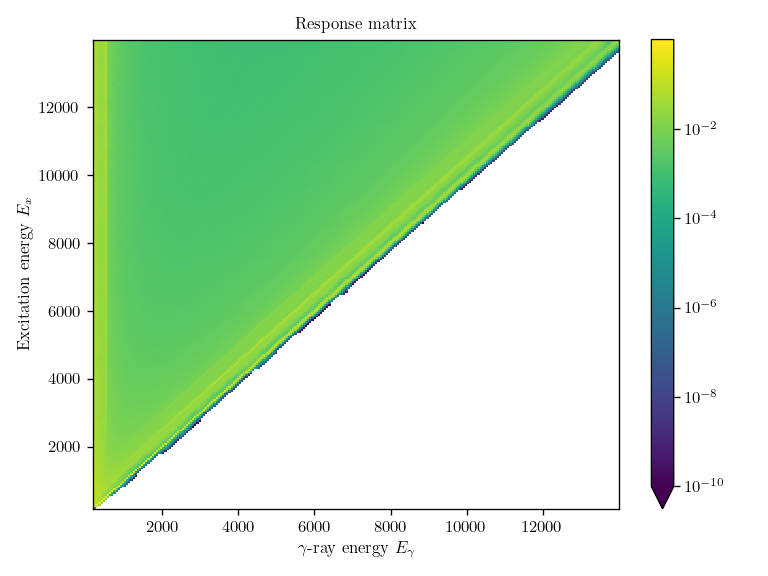

In [61]:
%matplotlib notebook
%matplotlib notebook
import numpy as np
import ompy as om
import fbu
import scipy.stats as st
import pymc3 as mc
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
from matplotlib import rc

dpi = 120
rc('figure',dpi = dpi)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
# rc('figure', figsize = (6,4))
rc('font', size=10)
rc('legend', fontsize = 10)
rc('axes', labelsize = 10)
rc('axes', titlesize = 10)
rc('xtick', labelsize = 10)
rc('ytick', labelsize = 10)

folderpath = "../../../ompy/OCL_response_functions/oscar2017_scale1.15"
response = om.Response(folderpath)
raw = om.Matrix(path="146Nd_data/Nd146raw_250ch.m")

# Background from file
bg = 1.2*om.Matrix(path="146Nd_data/Nd146raw_bg_250ch.m")

Eg = raw.Eg

# energy = Eg
###
energy = Eg[3:]
energy_bins = range(len(Eg))[3:]
###

raw.plot(title = 'Raw')
plt.tight_layout()
bg.plot(title = 'Background')
plt.tight_layout()
response_mat, R_tab_bay= response.interpolate(energy, fwhm_abs=30, return_table = True)

response_mat.plot(title="Response matrix", scale='log', vmin = 1e-10)


resp = response_mat.values

plt.tight_layout()
Emin = 6000
Emax = 6200
raw_folded, E = raw.projection(axis="Eg", Emin=Emin, Emax=Emax)
background, E = bg.projection(axis="Eg", Emin=Emin, Emax=Emax) 

###
raw_folded = raw_folded[3:]
background = background[3:]
###

<IPython.core.display.Javascript object>


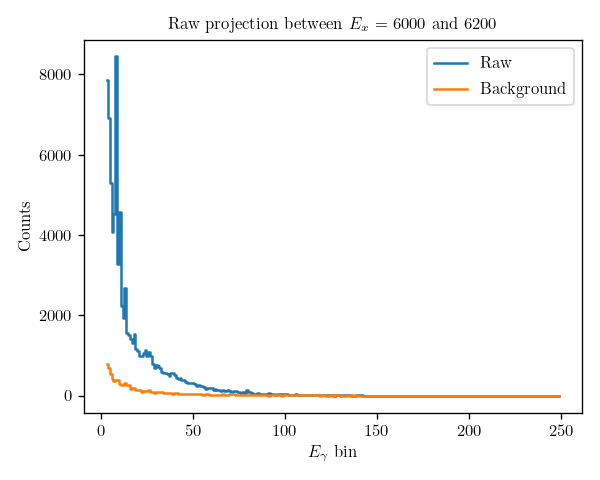

86466.0


In [62]:
%matplotlib notebook
%matplotlib notebook


plt.figure(figsize = (5,4))
plt.step(energy_bins,raw_folded, label = 'Raw', where  = 'mid')
plt.step(energy_bins,background, label = 'Background', where  = 'mid')

plt.title(r'Raw projection between $E_x$ = {} and {}'.format(Emin,Emax))
# plt.yscale('log')
plt.ylabel(r'Counts')
plt.xlabel(r'$E_\gamma$ bin')
plt.legend()
plt.tight_layout()
print(np.sum(raw_folded))
plt.show()

In [19]:
prior_l = np.ones(len(raw_folded))*1e-1
prior_u = np.maximum(raw_folded*10, 100*prior_l)


In [20]:
# Initiating FBU:
myfbu = fbu.PyFBU()
myfbu.response = resp
myfbu.data = raw_folded
myfbu.upper = prior_u   
myfbu.lower = prior_l

myfbu.background = {'bckg1': background}
myfbu.backgroundsyst = {'bckg1':0}


prior_choice = 1
# Standard uniform prior
if prior_choice == 0:
    myfbu.prior = 'Uniform'
    prior_random_sampling = st.uniform.rvs
    a = prior_l
    b = prior_u
    
    prior_args = [a,b]
    # No additional parameters
    prior_kwargs = dict()
    myfbu.priorparams = dict()

# Interpolated
if prior_choice == 1:
    myfbu.prior = 'Interpolated'
    x_values = []
    pdf_values = []
    for i in range(len(raw_folded)):
        x_temp = np.logspace(np.log10(prior_l[i]), np.log10(prior_u[i]), num = 10000)
        x_values.append(x_temp)
        pdf_values.append(1.0/x_temp)
        
    
    myfbu.priorparams = dict(non_kwargs=[x_values, pdf_values])
    # Arguments for prior sampling below, none needed
    prior_kwargs = dict()
    prior_args = []

In [21]:
print('Prior choice:', prior_choice)
myfbu.nTune = 1000
myfbu.nMCMC = 5000
myfbu.nChains = 2
# myfbu.nTune = 100000
# myfbu.nMCMC = 500000

myfbu.nCores = 4
myfbu.run()

Prior choice: 1
prior start
prior done


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


None


Average Loss = 1,008.7:  25%|██▍       | 49199/200000 [10:15<31:27, 79.90it/s]
Convergence achieved at 49200
Interrupted at 49,199 [24%]: Average Loss = 14,373
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [gaus_bckg1, truth246, truth245, truth244, truth243, truth242, truth241, truth240, truth239, truth238, truth237, truth236, truth235, truth234, truth233, truth232, truth231, truth230, truth229, truth228, truth227, truth226, truth225, truth224, truth223, truth222, truth221, truth220, truth219, truth218, truth217, truth216, truth215, truth214, truth213, truth212, truth211, truth210, truth209, truth208, truth207, truth206, truth205, truth204, truth203, truth202, truth201, truth200, truth199, truth198, truth197, truth196, truth195, truth194, truth193, truth192, truth191, truth190, truth189, truth188, truth187, truth186, truth185, truth184, truth183, truth182, truth181, truth180, truth179, truth178, truth177, truth176, truth175, truth174, truth173, truth172, truth171, truth170, truth169

Elapsed 0:59:08 (3.38 samples/second)


In [22]:
#Trace containing all the posteriors.
#Retrieves the N-dimensional posterior distribution in the form of a list of N arrays.
trace = myfbu.trace


In [23]:
# Calculating the HPD interval using PyMC3
hpd = mc.stats.hpd(np.array(trace).T, alpha = 1-0.68)   
means = np.mean(trace, axis = 1)
median = np.median(trace, axis = 1)
variance = np.var(trace, axis = 1)



Unfolded bin 5: 10922.435978005871 + rest: 66096.66899722443 = 77019.10497523031


<IPython.core.display.Javascript object>


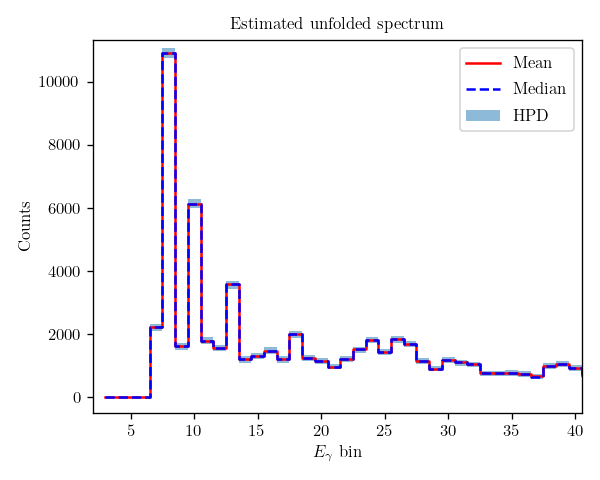

Mean variance true samples: 2570.3902243105854


In [64]:
%matplotlib notebook
%matplotlib notebook

print('Unfolded bin {}: {} + rest: {} = {}'.format(np.argmax(means), 
                                                   means[np.argmax(means)],
                                                   np.sum(means[:np.argmax(means)]) + 
                                                   np.sum(means[np.argmax(means)+1:]),
                                                   means[np.argmax(means)]+
                                                   np.sum(means[:np.argmax(means)]) + 
                                                   np.sum(means[np.argmax(means)+1:]))
)
# Plots with bin number on x-axis
plt.figure(figsize = (5,4))
plt.step(energy_bins, means, alpha = 1, ls='-', color = 'red', label = r'Mean', where = 'mid')
plt.fill_between(x = energy_bins, y1 = hpd[:,0], y2 = hpd[:,1], step = 'mid', alpha=0.5, label =r'HPD')
plt.step(energy_bins, median, ls='--', color = 'blue', alpha = 1, label = 'Median', where = 'mid')



# plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('$E_\gamma$ bin')
plt.title('Estimated unfolded spectrum')
plt.legend()

import matplotlib.lines as mlines

plt.legend() 
plt.tight_layout()

plt.show()

print('Mean variance true samples: {}'.format(variance.mean()))

<IPython.core.display.Javascript object>


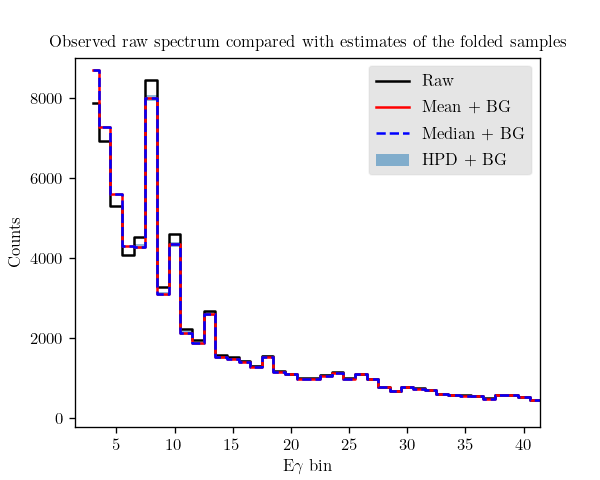

Mean absolute errors:
---------------------
Mean: 14.790104706672588
Median: 14.926162218211163

R2-scores:
---------------------
Mean: 0.9954757411304643
Median: 0.9954743720542943

Mean variance folded samples: 244.506549131978


In [65]:
%matplotlib notebook
%matplotlib notebook
plt.figure(figsize = (5,4))
# Folding all posterior samples
trace_array = np.array(trace)
# folded_samples = trace_array.T@resp

listtt = []
for i in range(len(trace[0])):
    listtt.append(trace_array.T[i]@resp)
folded_samples = np.array(listtt)

# Calculating the HPD interval using PyMC3, and its mean
folded_hpd = mc.stats.hpd(folded_samples, alpha = 1-0.68)   
folded_means = np.mean(folded_samples, axis = 0)
folded_medians = np.median(folded_samples, axis = 0)
folded_variance = np.var(folded_samples, axis = 0)

plt.step(energy_bins, raw_folded, label='Raw', color = 'black', where = 'mid')
plt.step(energy_bins, folded_means + background, color = 'red', alpha = 1, ls='-', label = r'Mean + BG', where = 'mid')
plt.fill_between(x = energy_bins, y1 = folded_hpd[:,0] + background, y2 = folded_hpd[:,1] + background, step = 'mid', alpha=0.5, label =r'HPD + BG')
plt.step(energy_bins, folded_medians + background, ls='--', color = 'blue', alpha = 1, label = 'Median + BG', where = 'mid')


plt.title('Observed raw spectrum compared with estimates of the folded samples')
plt.ylabel('Counts')
plt.xlabel(r'E$\gamma$ bin')
plt.legend(facecolor='grey', framealpha=0.2)
plt.show()

print('Mean absolute errors:')
print('---------------------')
print('Mean:', np.mean(np.abs(raw_folded - (folded_means + background))))
print('Median:', np.mean(np.abs(raw_folded - (folded_medians + background))))

print('\nR2-scores:')
print('---------------------')
print('Mean:', 1 - (np.sum((raw_folded - (folded_means + background))**2))/(np.sum((raw_folded - np.mean(raw_folded))**2)))
print('Median:', 1 - (np.sum((raw_folded - (folded_medians + background))**2))/(np.sum((raw_folded - np.mean(raw_folded))**2)))


print('\nMean variance folded samples: {}'.format(folded_variance.mean()))


In [54]:
%matplotlib notebook
%matplotlib notebook
plt.figure(figsize = (5,4))
print(means.shape)

# Compare the folded estimates with the raw spectrum
plt.step(energy_bins, raw_folded, label='Raw', color = 'black', where = 'mid')
plt.step(energy_bins, means@resp + background, color = 'red', ls='-', linewidth = 1, label = r'Mean + BG', where = 'mid')
plt.step(energy_bins, median@resp + background, ls='--', color = 'blue', linewidth = 1, label = 'Median + BG', where = 'mid')
plt.fill_between(x = energy_bins, y1 = (hpd[:,0])@resp + background, y2 = (hpd[:,1])@resp + background, step = 'mid', alpha=0.5, label =r'HPD + BG')



# plt.yscale('log')
plt.title('Observed raw spectrum compared with folded estimates + background')
plt.ylabel('Counts')
plt.xlabel(r'E$\gamma$ bin')
plt.legend(facecolor='grey', framealpha=0.2)
plt.show()

print('Mean absolute errors:')
print('---------------------')
print('Mean:', np.mean(np.abs(raw_folded - (means@resp + background))))
print('Median:', np.mean(np.abs(raw_folded - (median@resp + background))))

print('\nR2-scores:')
print('---------------------')
print('Mean:', 1 - (np.sum((raw_folded - (means@resp + background))**2))/(np.sum((raw_folded - np.mean(raw_folded))**2)))
print('Median:', 1 - (np.sum((raw_folded - (median@resp + background))**2))/(np.sum((raw_folded - np.mean(raw_folded))**2)))


<IPython.core.display.Javascript object>

(247,)
Mean absolute errors:
---------------------
Mean: 14.790104706672459
Median: 15.90216624000158

R2-scores:
---------------------
Mean: 0.9954757411304643
Median: 0.9957108905076238


In [27]:
# # Variance
# plt.figure(figsize = (5.5,4))
# plt.step(range(len(energy)), variance, label='Variance', color = 'green')
# plt.xlabel(r'E$\gamma$ bin')
# plt.ylabel(r'Variance')
# # plt.tight_layout()
# plt.title('Variance of true samples')

# plt.figure(figsize = (5,4))
# plt.step(range(len(energy)), folded_variance, label='Variance', color = 'green')
# plt.xlabel(r'E$\gamma$ bin')
# plt.ylabel(r'Variance')
# # plt.tight_layout()
# plt.title('Variance of folded samples')


# # Std. dev
# plt.figure(figsize = (5.5,4))
# plt.step(range(len(energy)), np.std(trace, axis = 1), label='Variance', color = 'green')
# plt.xlabel(r'E$\gamma$ bin')
# plt.ylabel(r'Std. dev')
# # plt.tight_layout()
# plt.title('Std. dev of true samples')

# plt.figure(figsize = (5,4))
# plt.step(range(len(energy)), np.std(folded_samples, axis = 0), label='Variance', color = 'green')
# plt.xlabel(r'E$\gamma$ bin')
# plt.ylabel(r'Std. dev')
# # plt.tight_layout()
# plt.title('Std. dev of folded samples')

# plt.show()

<IPython.core.display.Javascript object>


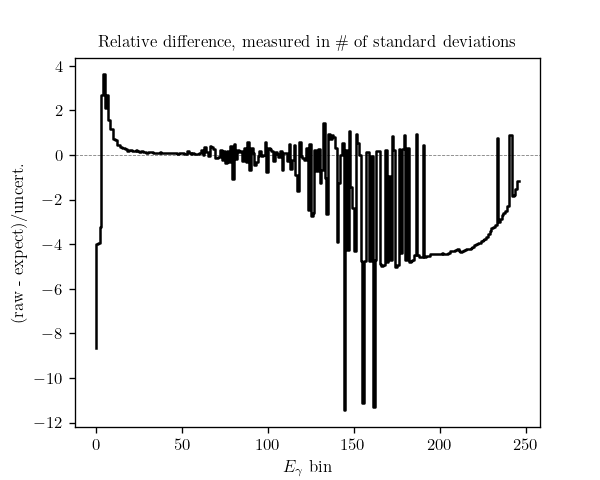

In [67]:
%matplotlib notebook
%matplotlib notebook

sigma_folded = np.std(folded_samples, axis = 0)
# Do not know if we have access to sigma_background, set to 0 
sigma_background = 0
sigma_stat = np.sqrt(raw_folded)
sigma_total = np.sqrt( sigma_stat**2 + sigma_folded**2 + sigma_background**2 )


plt.figure(figsize = (5,4))
plt.ylabel('(raw - expect)/uncert.')
plt.xlabel(r'$E_\gamma$ bin')
plt.title('Relative difference, measured in \# of standard deviations')

plt.axhline(y=0, color='grey', linestyle='--', alpha = 1, linewidth = 0.5)
plt.step(range(len(energy)), (raw_folded - folded_means - background) / sigma_total, label='sigma', color = 'black')

plt.show()

<IPython.core.display.Javascript object>


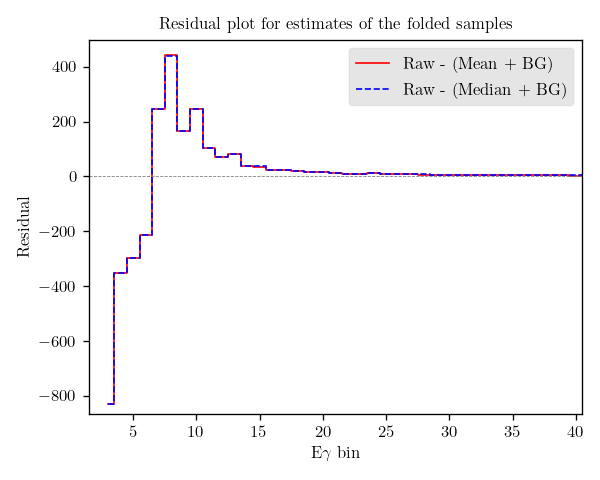

-34.304975230278075
20.38164342352811


In [66]:
%matplotlib notebook
%matplotlib notebook
# Residual plot
plt.figure(figsize = (5,4))
plt.step(energy_bins,raw_folded - (folded_means + background), color = 'red', ls='-', linewidth = 1, label = r'Raw - (Mean + BG)', where = 'mid')
plt.step(energy_bins,raw_folded - (folded_medians + background), ls='--', color = 'blue', linewidth = 1, label = 'Raw - (Median + BG)', where = 'mid')
plt.axhline(y=0, color='grey', linestyle='--', alpha = 1, linewidth = 0.5)
plt.title('Residual plot for estimates of the folded samples')
plt.ylabel('Residual')
plt.xlabel(r'E$\gamma$ bin')
plt.legend(facecolor='grey', framealpha=0.2)
plt.tight_layout()
plt.show()

print(np.sum((raw_folded - (folded_means + background))))
print(np.sum((raw_folded - (folded_medians + background))))

<IPython.core.display.Javascript object>


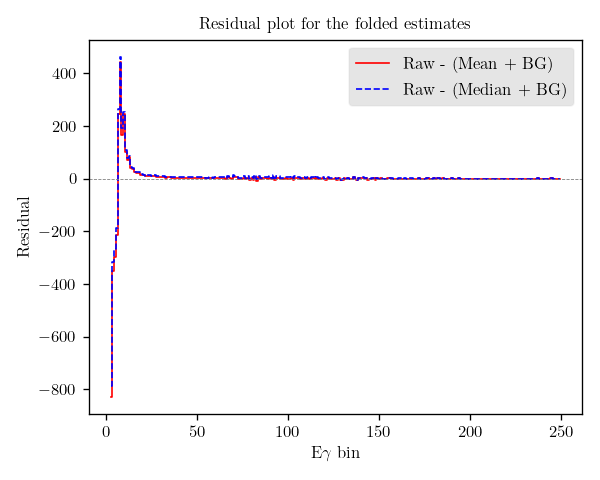

In [50]:
%matplotlib notebook
%matplotlib notebook
plt.figure(figsize = (5,4))
# Residual plot
plt.step(energy_bins,raw_folded - (means@resp + background), color = 'red', ls='-', linewidth = 1, label = r'Raw - (Mean + BG)', where = 'mid')
plt.step(energy_bins,raw_folded - (median@resp + background), ls='--', color = 'blue', linewidth = 1, label = 'Raw - (Median + BG)', where = 'mid')
plt.axhline(y=0, color='grey', linestyle='--', alpha = 1, linewidth = 0.5)
plt.title('Residual plot for the folded estimates')
plt.ylabel('Residual')
plt.xlabel(r'E$\gamma$ bin')
plt.legend(facecolor='grey', framealpha=0.2)
plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


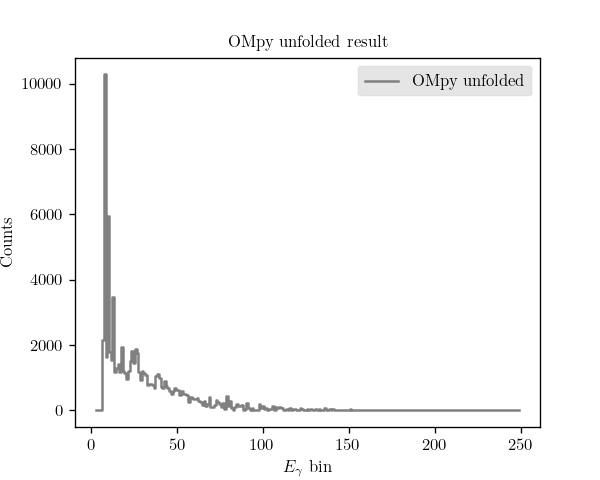

<IPython.core.display.Javascript object>


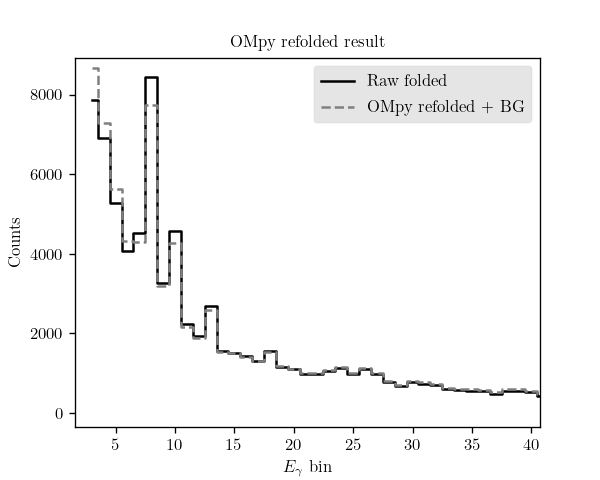

Mean absolute errors:
---------------------
Folded: 20.36426211898646
Folded: 20.36426211898646

R2-scores:
---------------------
Folded: 0.9942857398500423


In [56]:
# Folding iteration method
%matplotlib notebook
%matplotlib notebook

ompy_raw_bg_subtracted = raw_folded - background

response_ompy, table = response.interpolate(energy, fwhm_abs=30, return_table=True)

# The ompy unfolder requires a mock matrix if unfolding a 1D spectrum
ompy_raw = om.Matrix(np.array([ompy_raw_bg_subtracted, ompy_raw_bg_subtracted]), Eg = energy)

#
ompy_raw.remove_negative()
#
ompy_unfolder = om.Unfolder(response=response_ompy)
# Required for compton subtraction
ompy_unfolder.response_tab = table 

# The output is a tuple of 2 identical unfolded spectra, get the first
ompy_unfolded = ompy_unfolder(ompy_raw)[0]
ompy_folded = ompy_unfolded@response_ompy.values


unfolded_shortened = ompy_unfolded
folded_shortened = ompy_folded

plt.figure(figsize = (5,4))

plt.step(energy_bins, unfolded_shortened, color = 'grey', ls = '-', label = 'OMpy unfolded', where = 'mid')
plt.xlabel(r'$E_{\gamma}$ bin')
plt.ylabel('Counts')
plt.legend(facecolor='grey', framealpha=0.2)
plt.title('OMpy unfolded result')


raw_no_zeros = ompy_raw_bg_subtracted
plt.figure(figsize = (5,4))
plt.step(energy_bins, raw_folded, color = 'black', label = 'Raw folded', where = 'mid')
plt.step(energy_bins,folded_shortened + background, color = 'grey', ls = '--', label = 'OMpy refolded + BG', where = 'mid')
plt.xlabel(r'$E_{\gamma}$ bin')
plt.ylabel('Counts')
plt.legend(facecolor='grey', framealpha=0.2)
plt.title('OMpy refolded result')



plt.show()
print('Mean absolute errors:')
print('---------------------')
print('Folded:', np.mean(np.abs(raw_no_zeros + background - folded_shortened - background)))




print('\nR2-scores:')
print('---------------------')
print('Folded:', 1 - (np.sum((raw_folded - folded_shortened - background)**2))/(np.sum((raw_folded - np.mean(raw_no_zeros + background))**2)))

